### User Inputs

In [1]:
#where are the csvs from the paddock drill?
csvs = "/g/data1a/r78/cb3058/dea-notebooks/paddock_drill/results/WaggaWagga_2018/paddock_zonal/"

#what paddock are you interested in?
paddockID = 190
#what variable would you like to plot? 
#options are: Mean PV (%), Mean NPV (%), or Mean BS (%)
variable = 'Mean PV (%)'

### run these cells to produce plots

In [2]:
import datacube
import geopandas as gpd
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.utils import geometry
from matplotlib import pyplot as plt
from IPython.display import display
import ipywidgets as widgets
import datetime
import matplotlib as mpl
import fiona
import rasterio.features

import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, BandIndices, DEADataHandling
from query_from_shp import query_from_shp

import warnings
warnings.filterwarnings('ignore')

In [3]:
shp_fpath = '/g/data1a/r78/cb3058/dea-notebooks/paddock_drill/results/WaggaWagga_2018/WaggaWagga_2018_imageSeg_cultivated_polygons_withID.shp'

#set up query
time_period = ('2018-11-01', '2019-03-31')
query = query_from_shp(shp_fpath, time_period[0], time_period[1], dask_chunks = 0)
#landsat
dc = datacube.Datacube(app='whatever')
landsat = DEADataHandling.load_clearlandsat(dc, query, sensors=['ls8'],masked_prop=0.99)

#masking the returned array to the polygon area
with fiona.open(shp_fpath) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

mask = rasterio.features.geometry_mask([geom.to_crs(landsat.geobox.crs) for geoms in [geom]],
                                           out_shape=landsat.geobox.shape,
                                           transform=landsat.geobox.affine,
                                           all_touched=False,
                                           invert=True)
# Mask the xarrays
mask_xr = xr.DataArray(mask, dims = ('y','x'))
landsat = landsat.where(mask_xr==False)

In [15]:
import shapefile as shpf
cultivatedPolygons = shpf.Reader(shp_fpath)

In [31]:
import ipywidgets as widgets
def onclick_polygon_interrogation(event):
    global pixelx, pixely,Clickedpolygon, data, dt, ts
    pixelx, pixely = int(event.xdata), int(event.ydata)
    # Generate a point from the location
    Clickpoint = shapely.geometry.Point(pixelx, pixely)
    cultivatedShapes = cultivatedPolygons.shapes()
    # Find the polygon that contains the selected point
    Clickedpolygon = []
    for ix, shapes in enumerate(cultivatedPolygons.shapes()):
        if shapely.geometry.shape(shapes).contains(Clickpoint) == True:
            Clickedpolygon.append(ix)
    # Colour the chosen polygon on the figure
    x = [i[0] for i in cultivatedPolygons[Clickedpolygon[0]].points[:]]
    y = [i[1] for i in cultivatedPolygons[Clickedpolygon[0]].points[:]]

    plt.figure(fig.number)
    plt.plot(x, y, 'r')

    with fiona.open(shp_fpath) as shapes:
        paddockID = shapes[Clickedpolygon]['properties']['id']
    data = pd.read_csv(csvs + str(paddockID) + ".csv")
    dt = pd.to_datetime(data['dateTime'])
    ts = data[variable].values


Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


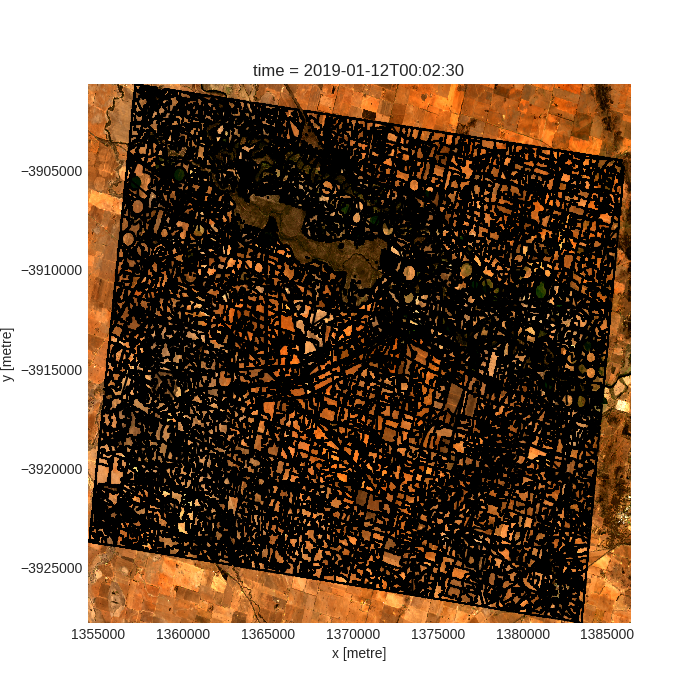

HTML(value='Click inside the polygon you would like to interrogate1372621')

In [34]:
%pylab notebook

fig, ax = plt.subplots(figsize=(7,7))
DEAPlotting.rgb(landsat, ax=ax, size=None,index=0, aspect=None)
for shape in cultivatedPolygons.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
plt.show()

w = widgets.HTML("Click inside the polygon you would like to interrogate" + str(pixelx))

cid = fig.canvas.mpl_connect('button_press_event', onclick_polygon_interrogation)
display(w)

NameError: name 'dt' is not defined

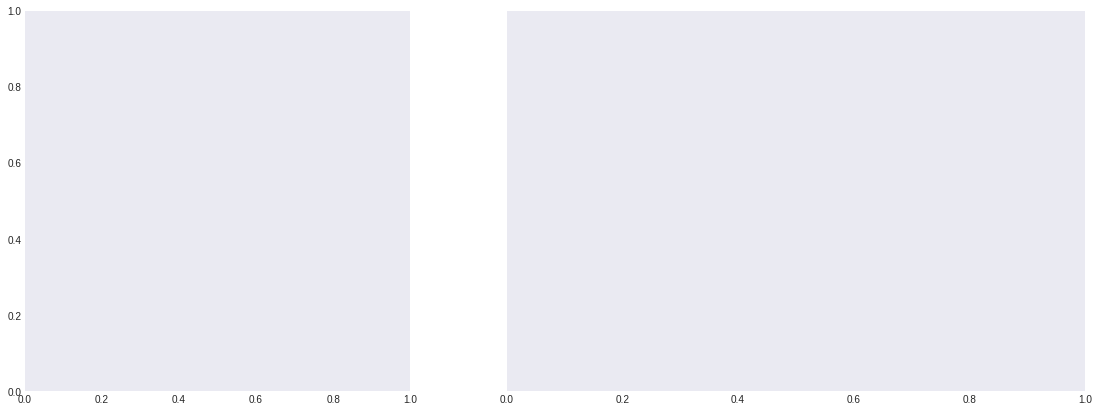

In [19]:
%matplotlib inline
## Now plot the phenology ##
mpl.style.use('seaborn-dark')
# fig = plt.figure(figsize=(15,10))
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(19,7),gridspec_kw = {'width_ratios':[1, 1.5]})

# Grabbing the day of year for the scatter plot
sp = ax1.scatter(dt.dt.dayofyear, ts, c=dt.dt.year,
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp, ax=ax1, shrink=1.0)

# If you want the months to show up as minor ticks...
month_doys = [datetime.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax1.xaxis.set_ticks(month_doys, minor=True)
ax1.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax1.xaxis.set_minor_locator(months)
ax1.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax1.grid(True)
ax1.set_xlim((0, 366))
ax1.set_ylim((0, 100))
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('PV %')
ax1.set_title('Phenology "DOY Plot"')

ax2.plot(dt, ts)
ax2.grid(True)
ax2.set_xlabel('Year')
ax2.set_title('Paddock ID: {}'.format(paddockID))

plt.tight_layout()

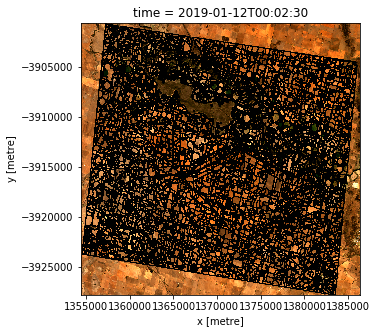

In [29]:
fig, ax = plt.subplots(figsize=(5,5))

DEAPlotting.rgb(landsat, ax=ax, size=None,index=0, aspect=None)

#bring in shapefile
import fiona
with fiona.open(shp_fpath, 'r') as shapefile:
    features = [feature["geometry"] for feature in shapefile]
ax = plt.gca()

#create a long list of colors to iterate over in the plot shapefile code
from random import randint
colors = []
for i in range(8500):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

#plot the shapefile
from descartes import PolygonPatch
import matplotlib as mpl
patches = [PolygonPatch(feature,
                        facecolor="none",
                        linewidth=1,label='Label') for feature in features]
ax.add_collection(mpl.collections.PatchCollection(patches, match_original=True))



In [ ]:
data = pd.read_csv(csvs + str(paddockID) + ".csv")
dt = pd.to_datetime(data['dateTime'])
ts = data[variable].values

## Now plot the phenology ##
mpl.style.use('seaborn-dark')
# fig = plt.figure(figsize=(15,10))
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(19,7),gridspec_kw = {'width_ratios':[1, 1.5]})

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax1.scatter(dt.dt.dayofyear, ts, c=dt.dt.year,
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp, ax=ax1, shrink=1.0)
# ax.plot(dt.dt.dayofyear, ts)

# If you want the months to show up as minor ticks...
month_doys = [datetime.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax1.xaxis.set_ticks(month_doys, minor=True)
ax1.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax1.xaxis.set_minor_locator(months)
ax1.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax1.grid(True)
ax1.set_xlim((0, 366))
ax1.set_ylim((0, 100))
ax1.set_xlabel('Day of Year')
ax1.set_ylabel('PV %')
ax1.set_title('Phenology "DOY Plot"')

ax2.plot(dt, ts)
ax2.grid(True)
ax2.set_xlabel('Year')
ax2.set_title('Paddock ID: {}'.format(paddockID))

plt.tight_layout()